In [56]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch_geometric.utils.convert import from_networkx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
import joblib

In [57]:
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [58]:
# Load the model
input_size = 7
hidden_size = 512
output_size = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("./models/gcn_nabil.pth", map_location=device))
model = model.to(device)
model.eval()


C:\Users\acer\AppData\Local\Temp\ipykernel_19608\3043813383.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/gcn_nabil.pth", ma

GCN(
  (conv1): GCNConv(7, 512)
  (conv2): GCNConv(512, 512)
  (lin): Linear(in_features=512, out_features=7, bias=True)
)

In [60]:
graphs = torch.load("./graphs/cb_nabil.pt", weights_only=False)
train, val = train_test_split(graphs, test_size=0.2, random_state=12)
train_graphs = DataLoader(train, batch_size=32, shuffle=True)
val_graphs = DataLoader(val, batch_size=32, shuffle=False)
test_load = torch.load("./graphs/cb_nabil_test.pt")
test_graphs = DataLoader(test_load, batch_size=32, shuffle=False)

C:\Users\acer\AppData\Local\Temp\ipykernel_19608\4162228958.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_load = torch.load("./graphs/cb_nabil_test.pt")


In [61]:
# Function to generate predictions
def generate_predictions(graphs):
    predictions = []
    ground_truth = []
    for batch in graphs:
        batch = batch.to(device)
        with torch.no_grad():
            output = model(batch.x, batch.edge_index, batch.batch)
            output = output.view(-1)
            predictions.append(output.cpu().numpy())
            ground_truth.append(batch.y.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    ground_truth = np.concatenate(ground_truth, axis=0)

    # Reshape to match the original feature dimensions
    predictions = predictions.reshape(-1, output_size)
    ground_truth = ground_truth.reshape(-1, output_size)

    # Inverse transform to the original scale
    predictions_original = scaler.inverse_transform(predictions)
    ground_truth_original = scaler.inverse_transform(ground_truth)

    # Convert to DataFrames
    predictions_df = pd.DataFrame(predictions_original, columns=df.columns)
    ground_truth_df = pd.DataFrame(ground_truth_original, columns=df.columns)

    # Add a 'published_date' column for plotting
    predictions_df['published_date'] = np.arange(len(predictions_df))
    ground_truth_df['published_date'] = np.arange(len(ground_truth_df))

    return predictions_df, ground_truth_df


In [62]:
# Generate predictions for validation and test sets
val_predictions_df, val_ground_truth_df = generate_predictions(val_graphs)
test_predictions_df, test_ground_truth_df = generate_predictions(test_graphs)


In [63]:
test_ground_truth_df.head()

,open,high,low,close,per_change,traded_quantity,traded_amount,published_date
0,583.000000,588.400024,579.5,583.000000,-0.34,44667.000000,26055976.0,0
1,580.199951,584.599976,580.0,581.700012,-0.36,54791.000000,31828814.0,1
2,571.999939,575.000000,568.0,569.000061,-0.49,60468.003906,34434416.0,2
3,577.999939,578.000000,566.5,568.000000,0.19,30777.000000,17493800.0,3
4,596.499939,596.499939,586.0,590.000000,0.08,66181.000000,39090480.0,4


In [64]:
test_predictions_df.head()

,open,high,low,close,per_change,traded_quantity,traded_amount,published_date
0,580.500610,573.783081,565.964294,557.609131,-0.215758,50786.765625,23337144.0,0
1,578.284973,570.746155,563.540527,555.033936,-0.186555,52725.726562,24393120.0,1
2,569.926697,562.374634,556.624207,548.414124,-0.189233,48634.820312,21525334.0,2
3,551.177246,543.017273,538.368835,529.816956,-0.208722,47153.011719,19794828.0,3
4,566.377136,558.893005,551.438904,541.500977,-0.171638,58693.414062,27293632.0,4


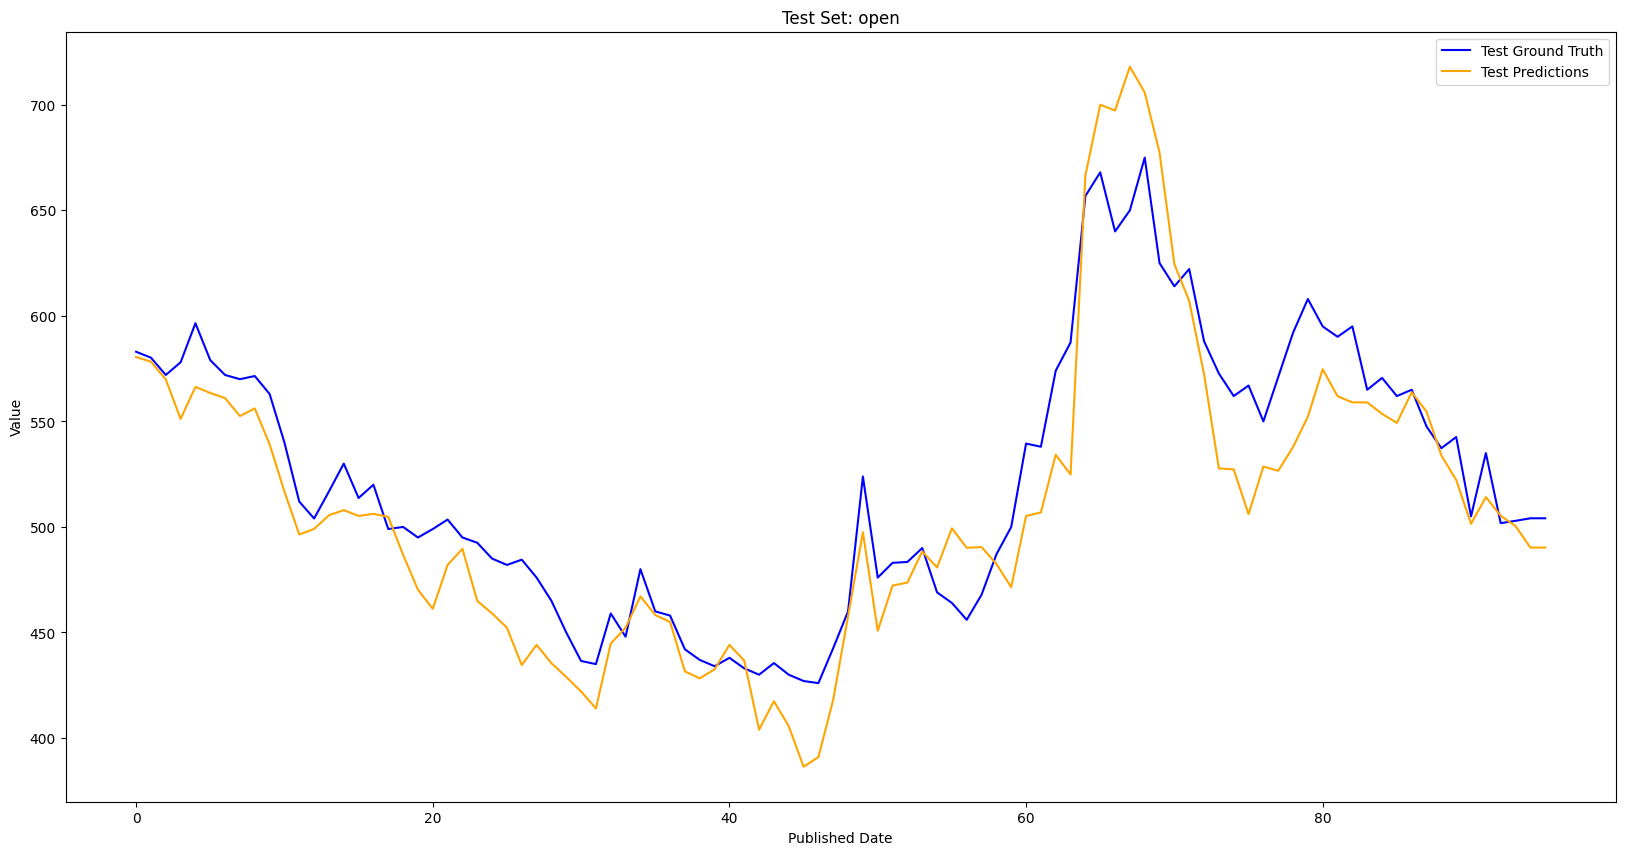

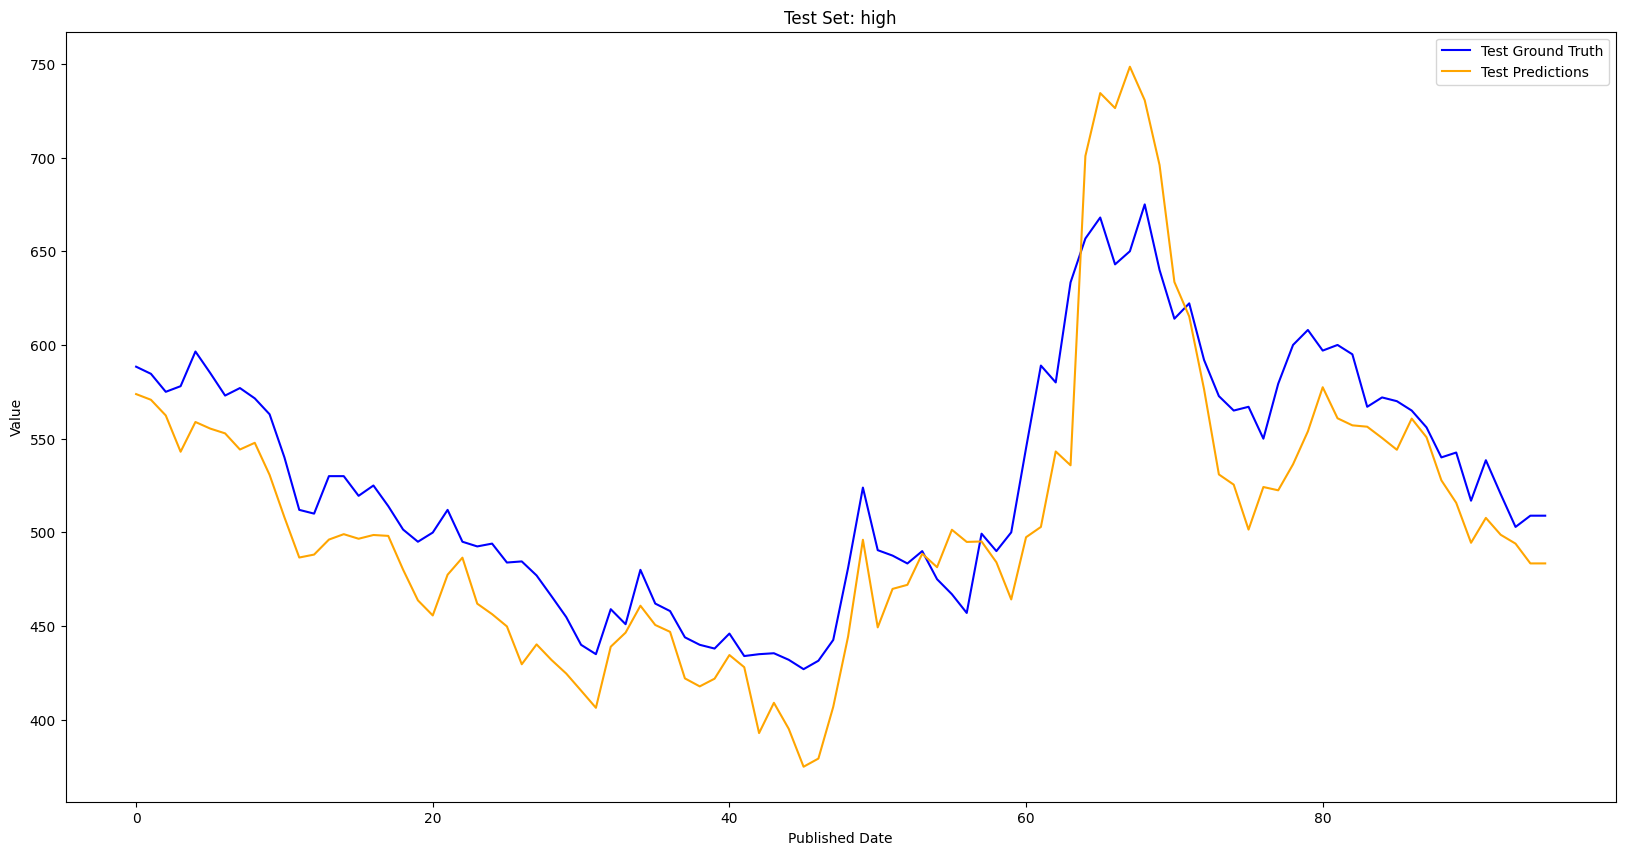

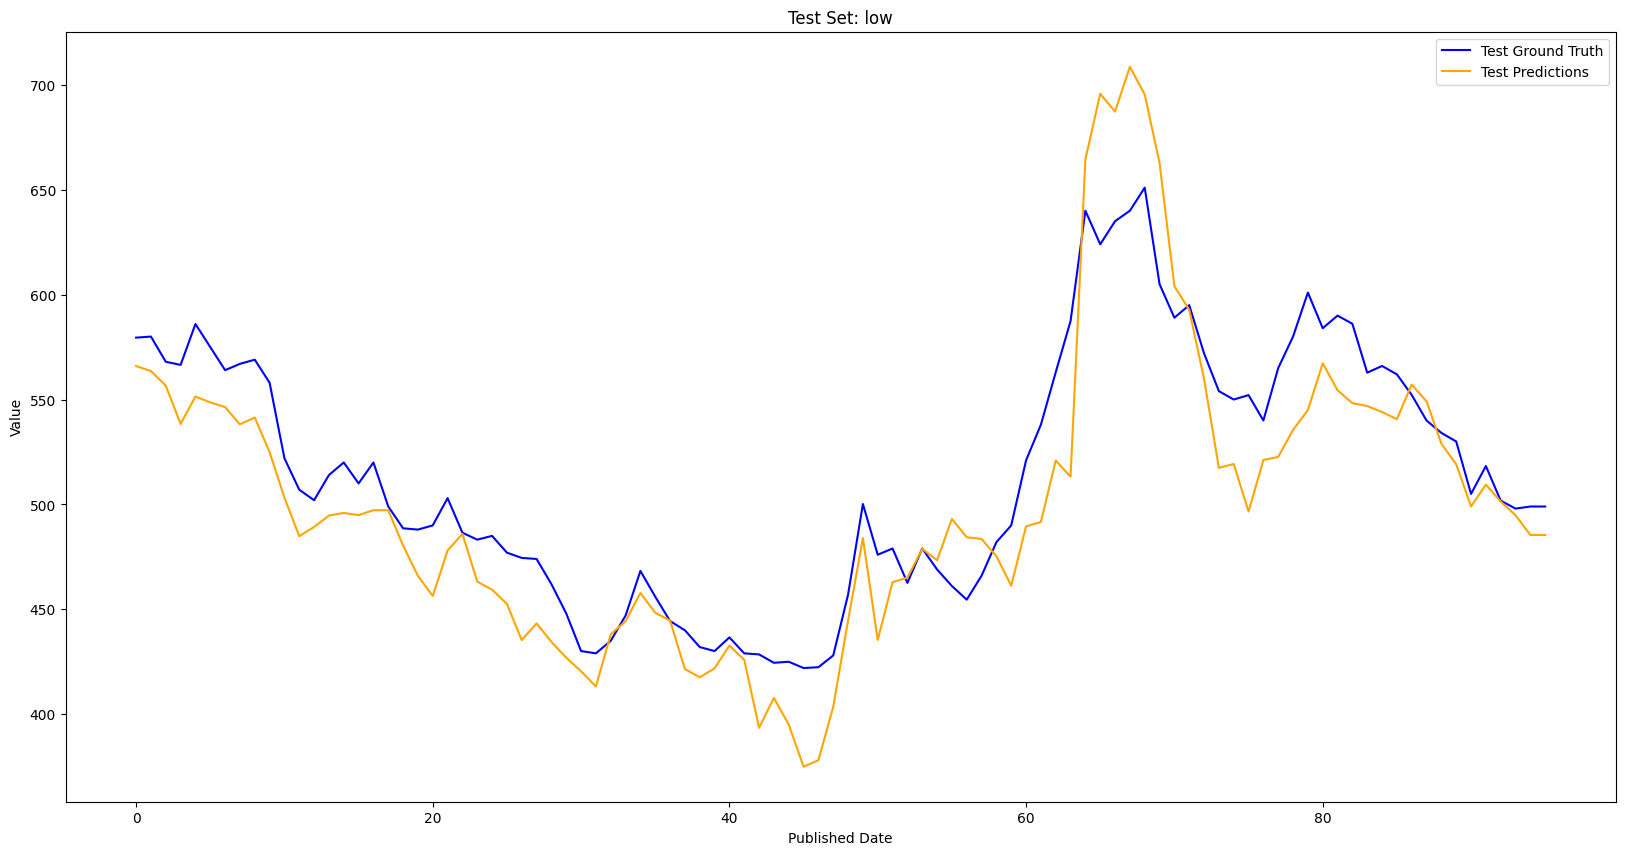

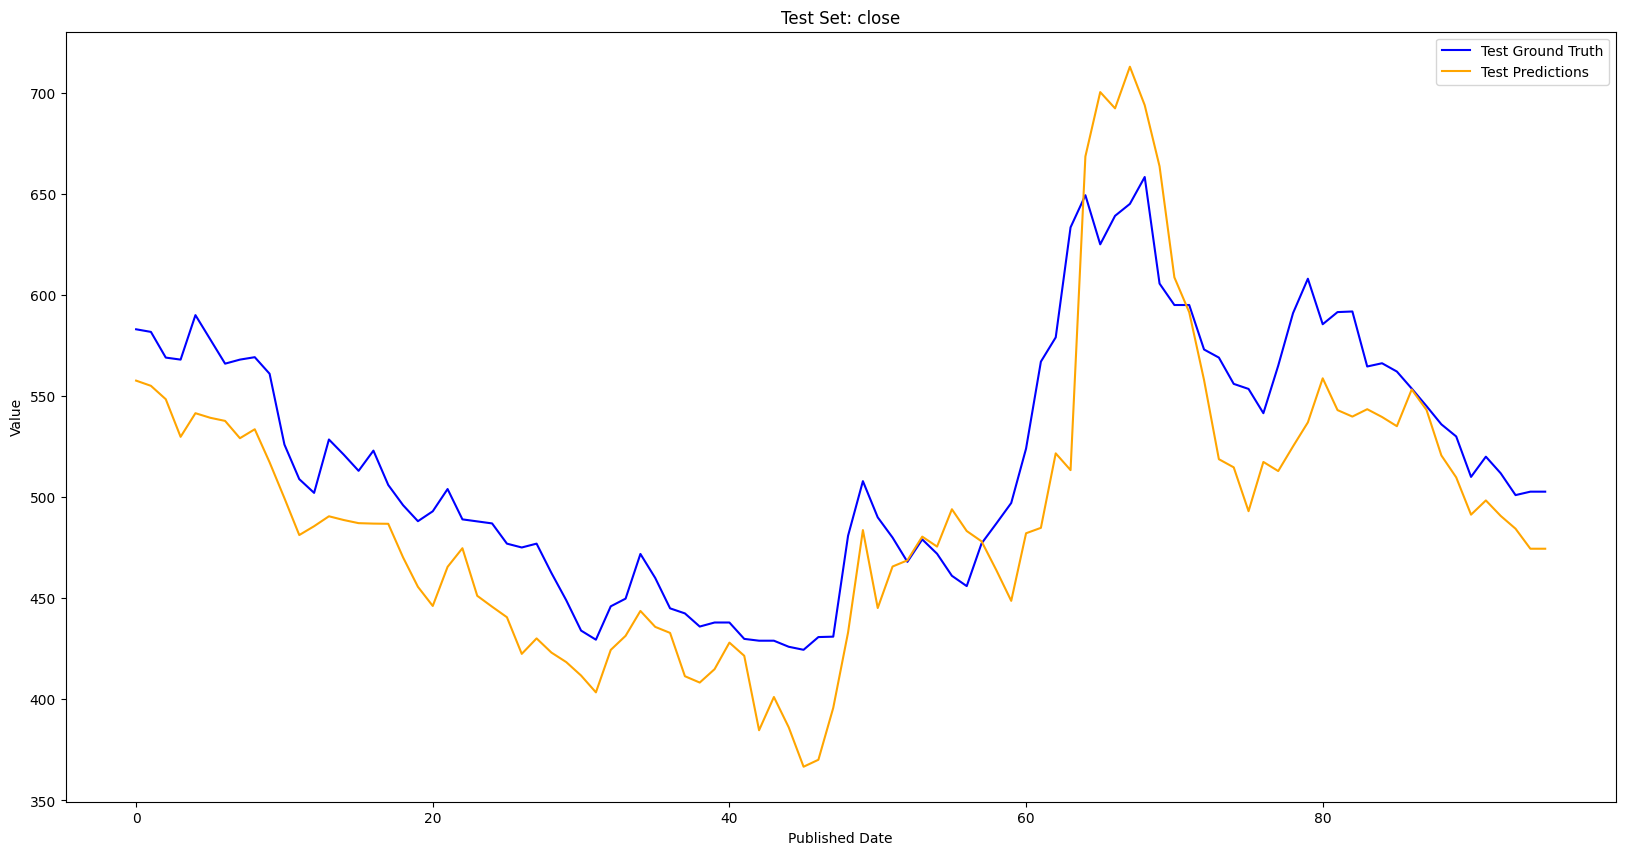

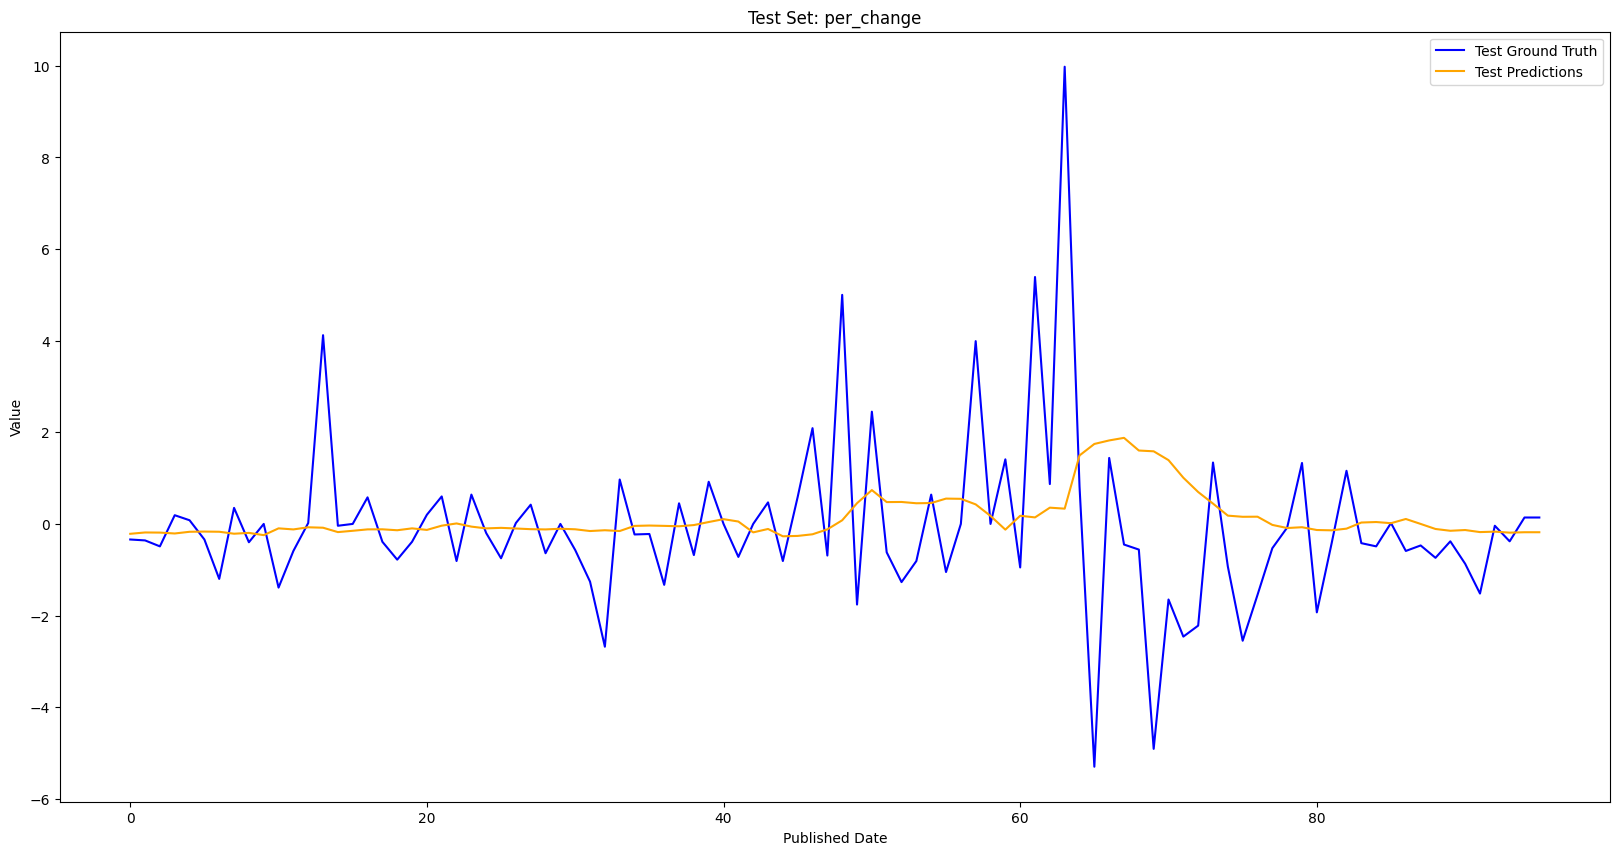

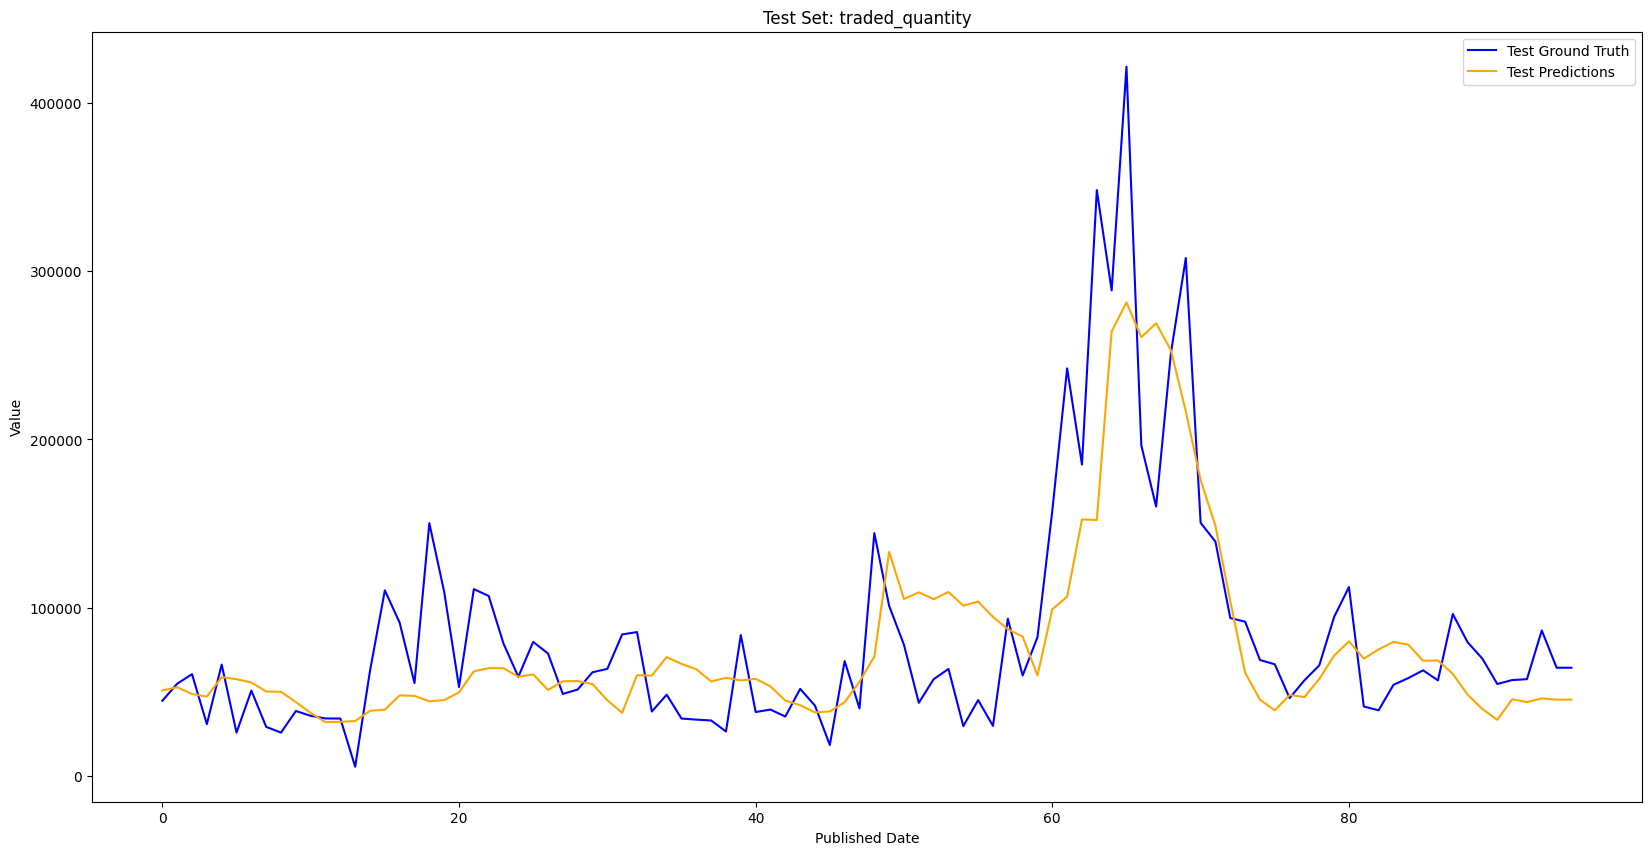

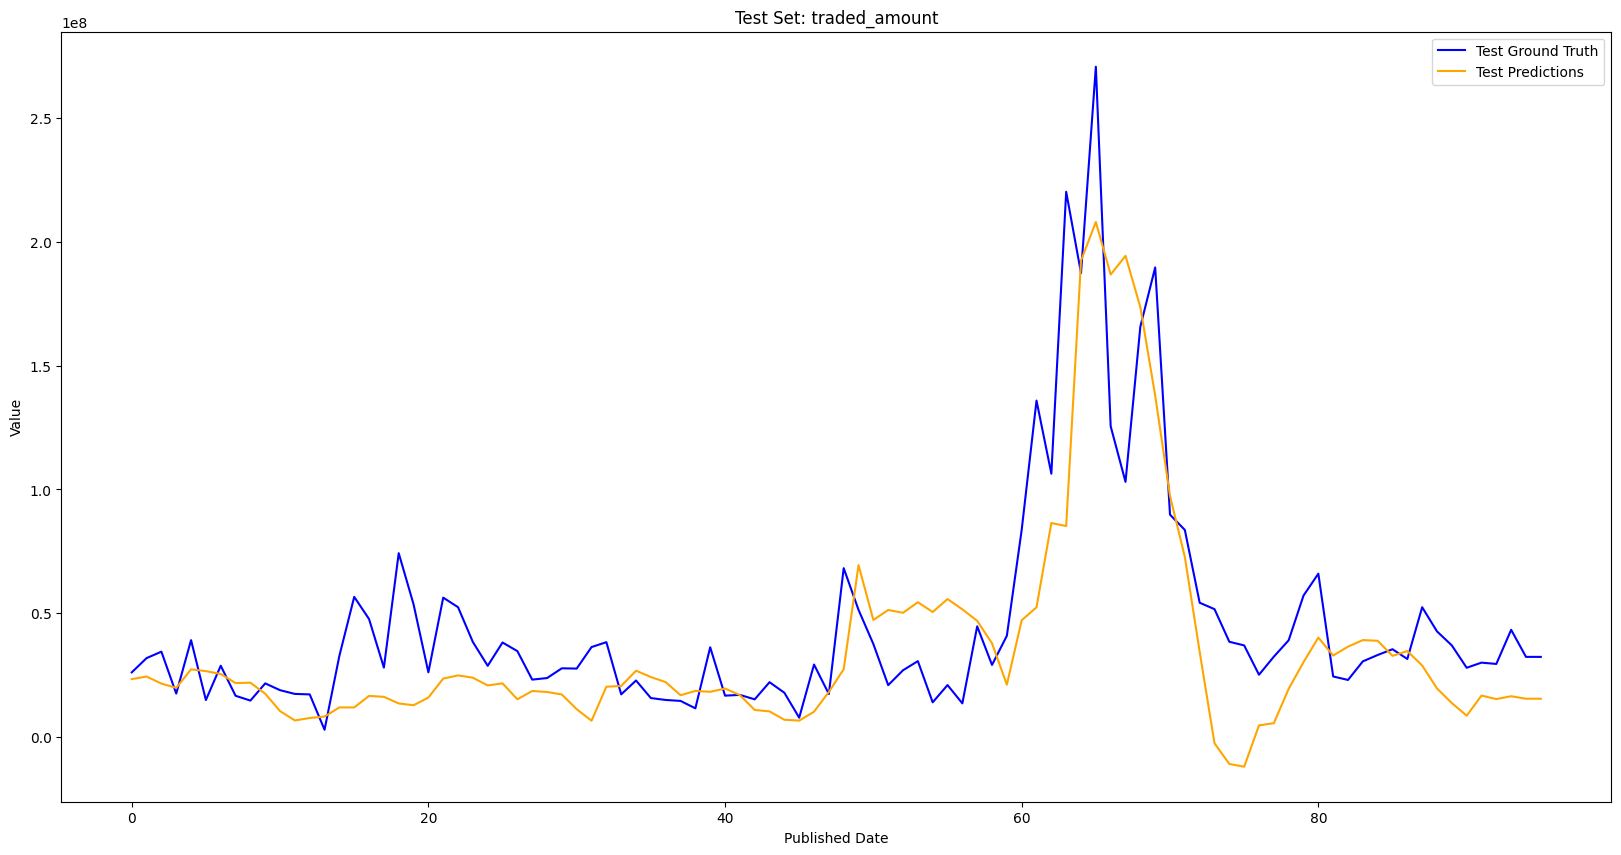

In [65]:
# Plot test set
for col in df.columns:
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=test_ground_truth_df, x='published_date', y=col, color="blue", label="Test Ground Truth")
    sns.lineplot(data=test_predictions_df, x='published_date', y=col, color="orange", label="Test Predictions")
    plt.title(f"Test Set: {col}")
    plt.xlabel('Published Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()